In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')
import time
import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

import diffrax
import ehtplot.color
import ehtim as eh
import ehtim.const_def as ehc
import flax
from flax.training import checkpoints
import IPython.display as ipd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

from configs import dpi_config as dpi_config_provider
from configs import score_config as score_config_provider

import ehtim_utils
import forward_models
import probability_bound
import probability_flow
from posterior_sampling import model_utils as dpi_mutils
from score_flow import utils
from score_flow.models import utils as score_mutils
from score_flow.models import ddpm, ncsnpp, ncsnv2

Welcome to eht-imaging! v 1.2.5 



2024-02-06 22:55:38.820140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Posterior Sampling with Surrogate Score-based Priors: Nonconvex Interferometric Imaging

In this notebook, we will perform variational inference with a score-based prior to solve the inverse problem of imaging a black hole from interferometric measurements. The test image is a simulated black-hole image, and the score-based prior was trained on simulated black-hole images (not including the test image). We will use the surrogate score-based prior as given by the evidence lower bound (ELBO).

In [2]:
"""
We define settings for this experiment through a `ConfigDict` for DPI.
A `ConfigDict` for the score model is used to help load the score-based prior.
"""

# Get DPI config.
config = dpi_config_provider.get_config()

config.data.image_size = 64  # This determines the pixel grid used in imaging.
config.data.num_channels = 1

config.likelihood.likelihood = 'Interferometry'
config.likelihood.interferometry.obs_path1 = 'eht_data/obs.uvfits'
config.likelihood.interferometry.image_path = 'eht_data/truth.fits'
config.likelihood.interferometry.zbl = 2.  # zero-baseline flux
config.likelihood.interferometry.fov_uas = 160  # FOV of image
config.likelihood.interferometry.target_flux = 173.  # This depends on the preferred flux of the prior.

config.model.n_flow = 32
config.model.seqfrac = 4

config.training.batch_size = 64
config.optim.learning_rate = 1e-5
config.optim.grad_clip = 1.
config.optim.prior = 'dsm'  # Change to 'ode' to use exact log-probabilities.
config.optim.adam_eps = 1e-8
config.optim.anneal_data = True

# Get score-model config.
score_config = score_config_provider.get_config()
score_config.model.beta_max = 20.
score_config.model.nf = 64

image_shape = (config.data.image_size, config.data.image_size, config.data.num_channels)
image_dim = np.prod(image_shape)

## Interferometry

The EHT performs very-long-baseline interferometry (VLBI) with a global array of telescopes. Each pair of telescopes $(i,j)$ provides a Fourier measurement called a *visibility*. The van Cittert-Zernike Theorem gives the ideal visibility $v^*_{ij}$ as
$$
v^*_{ij}= \int\int I(x,y)e^{-2\pi\text{i}(xu+yv)}\mathrm{d}x\mathrm{d}y,
$$
where $I(x,y)$ is the source image, $(x,y)$ are 2D spatial coordinates, and $(u,v)$ (measured in wavelengths) are the projected baseline orthogonal to the line of sight.

However, due to thermal noise and station-dependent errors, the observed visibility $v_{ij}$ is a corrupted version of the ideal visibility:
$$
v_{ij}=g_ig_je^{\text{i}(\phi_i-\phi_j)}v^*_{ij}+\varepsilon_{ij},
$$
where $g_i$ is the station-dependent gain error, and $\phi_i$ is the station-dependent phase error. We model the thermal noise as $\varepsilon_{ij}\sim\mathcal{N}(0,\sigma_{ij}^2)$ for a baseline-dependent $\sigma_{ij}$.

To overcome station-dependent errors, we turn to closure quantities. A *closure phase* is formed from a triplet of telescopes $(i,j,k)$ and is robust to phase errors. A *log closure amplitude* is formed from a set of four telescopes $(i,j,k,\ell)$ and is robust to gain errors. They are given repspectively as 
\begin{align*}
y^\text{cp}_{ijk}&=\angle(v_{ij}v_{jk}v_{ki}) \quad\text{and}\quad y^\text{logca}_{ijk\ell} = \log\left(\frac{\lvert v_{ij} \rvert \lvert v_{k\ell} \rvert}{\lvert v_{ik} \rvert \lvert v_{j\ell} \rvert} \right).
\end{align*}

In this demo, we use closure quantities to reconstruct an image from corrupted visibilities. The visibilities were simulated with [eht-imaging](https://github.com/achael/eht-imaging) for an image of a GRMHD [1] simulation of a black hole. 


[1] George Wong et al. PATOKA: Simulating Electromagnetic Observables of Black Hole Accretion. The Astrophysical Journal Supplement Series, 2022.

Loading uvfits:  eht_data/obs.uvfits
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


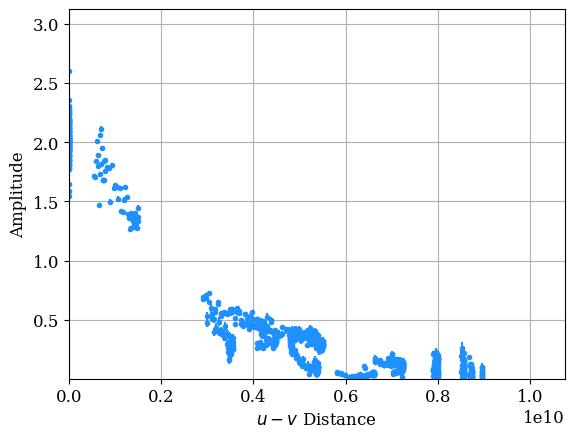

In [3]:
"""
The simulated visibilities are stored in an `eh.obsdata.Obsdata` object,
which also has metadata about the observations.
"""
obs = eh.obsdata.load_uvfits(
  config.likelihood.interferometry.obs_path1, remove_nan=False)

# View amplitudes of observed visibilities as a function of u-v distance.
obs.plotall('uvdist', 'amp');

Loading fits image:  eht_data/truth.fits


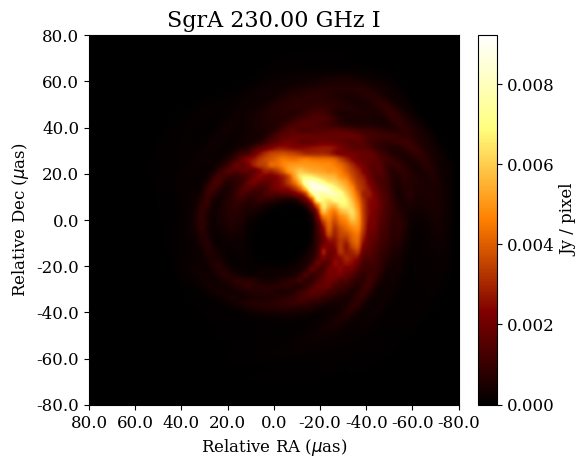

In [4]:
"""
The observations were simulated for the following synthetic image,
which we regrid to the desired FOV and pixel size.
"""
fov = config.likelihood.interferometry.fov_uas * ehc.RADPERUAS
true_im = eh.image.load_fits(config.likelihood.interferometry.image_path)
true_im = true_im.regrid_image(fov, config.data.image_size)
true_im.display();

In [5]:
"""
We wrap the observations and measurement-likelihood functions inside
the `forward_models.Interferometry` object.
"""
likelihood_obs = obs.copy()  # Make a copy before it gets modified by likelihood module.
# Make a dummy image to store imaging parameters (e.g., pixel grid, FOV).
dummy_im = eh.image.make_square(obs, config.data.image_size, fov)
likelihood = forward_models.Interferometry(likelihood_obs, dummy_im)

Updated self.amp: no averaging
Updated self.amp: avg_time 0.000000 s

Updated self.cphase: no averaging
updated self.cphase: avg_time 0.000000 s

updated self.lcamp: no averaging
updated self.logcamp: avg_time 0.000000 s

Using pre-computed cphase table in cphase chi^2!
Using pre-computed log closure amplitude table in log closure amplitude chi^2!


## Score-based prior

It is possible to compute $\log p_\theta(\mathbf{x})$ for any image $\mathbf{x}$ under the score-based prior $p_\theta$. However, since it relies on an ODE that might be too slow for $64\times 64$ images, we opt for a surrogate score-based prior. The surrogate is defined through the ELBO $b_\theta(\cdot)$ of the score-based prior:
$$
b_\theta(\mathbf{x})=\mathbb{E}_{p_{0T}(\mathbf{x}'\mid\mathbf{x})}\left[\log \pi (\mathbf{x}')\right] -\frac{1}{2}\int_0^T g(t)^2h(t)\mathrm{d}t,
$$
where
$$
h(t):= \mathbb{E}_{p_{0t}(\mathbf{x}'\mid\mathbf{x})}\bigg[\left\lVert\mathbf{s}_\theta(\mathbf{x}',t) -\nabla_{\mathbf{x}'}\log p_{0t}(\mathbf{x}'\mid\mathbf{x})\right\rVert_2^2 -\left\lVert\nabla_{\mathbf{x}'}\log p_{0t}(\mathbf{x}'\mid\mathbf{x})\right\rVert_2^2 -\frac{2}{g(t)^2}\nabla_{\mathbf{x}'}\cdot\mathbf{f}(\mathbf{x}',t)\bigg].
$$
$p_{0t}(\mathbf{x}'\mid\mathbf{x})$ denotes the transition distribution from $\mathbf{x}(0)=\mathbf{x}$ to $\mathbf{x}(t)=\mathbf{x}'$ under the diffusion SDE with drift coefficient $\mathbf{f}(\mathbf{x},t)$ and diffusion coefficient $g(t)$. In practice we Monte-Carlo approximate the time integral with $1$ importance-sampled time value and the expectation over $p_{0t}(\mathbf{x}'\mid\mathbf{x})$ with $1$ sample of $\mathbf{x}'$.

In [6]:
"""
This score-based prior was trained on images of GRMHD simulations.
"""
score_model_ckpt_path = '../score_checkpoints/GRMHD_64/checkpoints/checkpoint_100000'

# Get SDE.
sde, t0 = utils.get_sde(score_config)

# Initialize score model.
score_model, _, _ = score_mutils.init_model(jax.random.PRNGKey(0), score_config)
score_state = score_mutils.State(
    step=0,
    model_state=None,
    opt_state=None,
    ema_rate=score_config.model.ema_rate,
    params=None,
    params_ema=None,
    rng=jax.random.PRNGKey(0))

# Load score-model checkpoint.
score_state = checkpoints.restore_checkpoint(score_model_ckpt_path, score_state)

# Get score function based on trained score model.
score_fn = score_mutils.get_score_fn(
  sde,
  score_model,
  score_state.params_ema,
  score_state.model_state,
  train=False,
  continuous=True)

# Wrap probability flow ODE computations inside `probability_flow.ProbabilityFlow`.
# We will use this to sample from the prior and, if `config.optim.prior == 'ode'`,
# to compute log-probabilities.
solver = diffrax.Dopri5()
stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-5)
# NOTE: it might be possible to use `diffrax.RecursiveCheckpointAdjoint`
# instead of `BacksolveAdjoint`.
adjoint = diffrax.BacksolveAdjoint(
  solver=diffrax.Dopri5(),
  stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5, norm=diffrax.adjoint_rms_seminorm))
prob_flow = probability_flow.ProbabilityFlow(
  sde=sde,
  score_fn=score_fn,
  solver=solver,
  stepsize_controller=stepsize_controller,
  adjoint=adjoint,
  n_trace_estimates=16)

# Get function for computing ELBO, which is used if `config.optim.prior == 'dsm'`.
bound_fn = probability_bound.get_likelihood_bound_fn(
    sde, score_fn, image_dim,
    dsm=True, eps=t0, N=config.optim.dsm_nt, importance_weighting=True,
    eps_offset=True)

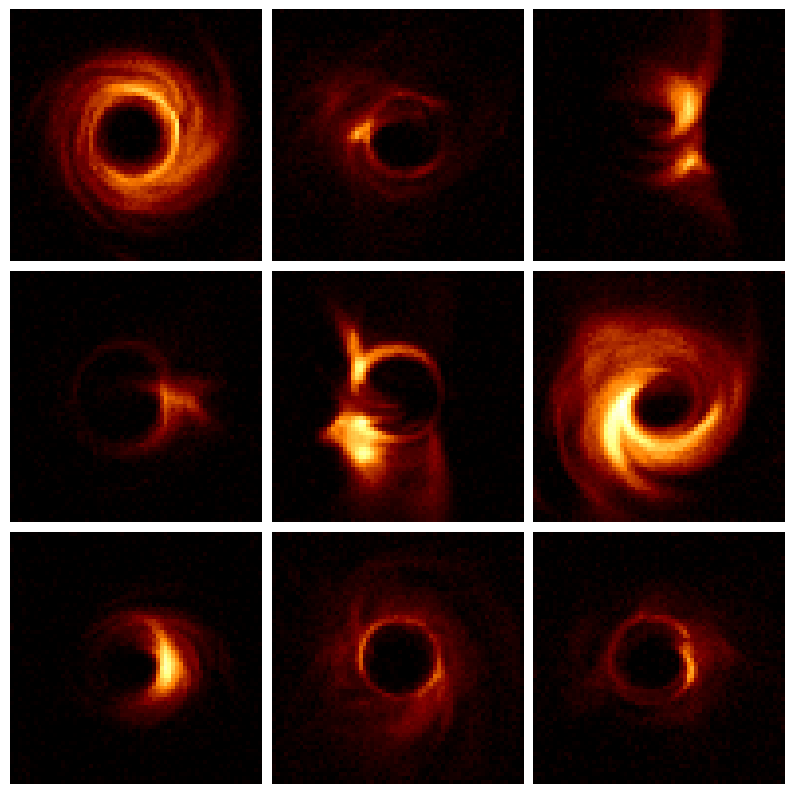

In [7]:
"""
Check that samples look reasonable using the ODE.
"""
z = jax.random.normal(jax.random.PRNGKey(0), (9, *image_shape))
samples, _ = prob_flow.ode(z, sde.T, t0, dt0=None)
utils.plot_image_grid(samples[:9], cmap='afmhot');

## DPI optimization

We wish to sample from the posterior
$$
p_\theta(\mathbf{x}\mid\mathbf{y})\propto p(\mathbf{y}\mid\mathbf{x})p_\theta(\mathbf{x}),
$$
where $p(\mathbf{y}\mid\mathbf{x})$ is the measurement likelihood for closure quantities $\mathbf{y}$, and $p_\theta(\mathbf{x})$ is the probability of $\mathbf{x}$ under the score-based prior.

In DPI, we approximate the posterior with a RealNVP normalizing flow with parameters $\phi$. The RealNVP generates the image distribution $q_\phi$, which we optimize to best-approximate the target posterior. With the surrogate score-based prior, we minimize an upper bound of the KL divergence from $q_\phi$ to $p_\theta(\cdot\mid\mathbf{y})$:
\begin{align*}
D_{\text{KL}}(q_\phi\lVert p_\phi(\cdot\mid y) &= \mathbb{E}_{\mathbf{x}\sim q_\phi}[-\log p(y\mid\mathbf{x})-\log p_\phi(\mathbf{x})+\log q_\phi(\mathbf{x})] \\
&\leq \mathbb{E}_{\mathbf{x}\sim q_\phi}[-\log p(y\mid\mathbf{x})-b_\phi(\mathbf{x})+\log q_\phi(\mathbf{x})].
\end{align*}

When imaging from closure quantities, the total flux (i.e., sum of the pixel values) of the image is unconstrained. To impose an additional assumption that images from the posterior must all have a certain total flux, we add a flux-constraint loss $\left(V(\mathbf{x})-\bar{V}\right)^2$, where $V(\mathbf{x})$ is the total flux of $\mathbf{x}$, and $\bar{V}$ is the target total flux. $\bar{V}$ can be chosen as the preferred total flux of the score-based prior (e.g., by computing the median total flux of samples from the prior).

To summarize, the optimization problem is
$$
\phi^* = \arg\min_\phi \mathbb{E}_{\mathbf{x}\sim q_\phi}[-\log p(y\mid\mathbf{x})-b_\phi(\mathbf{x})+\left(V(\mathbf{x})-\bar{V}\right)^2+\log q_\phi(\mathbf{x})].
$$

In [8]:
"""
Here we define the objective functions and update step for the RealNVP.
"""

sampling_shape = (config.training.batch_size // jax.local_device_count(), *image_shape)

# Define data loss function (aka negative log measurement likelihood).
# NOTE: weights need to be multiplied by number of data points because
# `forward_models.Interferometry.data_fit_loss` computes chi-squared,
# which normalizes for the number of data points (unlike -logp(y|x)).
vis_weight = 0
visamp_weight = 0
cphase_weight = len(likelihood.cphase) * 0.5
logcamp_weight = len(likelihood.logcamp) * 0.5
def data_loss_fn(x):
  data_losses = likelihood.data_fit_loss(
    x, vis_weight, visamp_weight, cphase_weight, logcamp_weight)
  return jnp.mean(data_losses)

# Define annealing function for data weight. This is used if `config.optim.anneal_data` is `True`.
def data_weight_fn(step, rate, pivot_steps):
  """Sigmoidal annealing function for data weight increase. Assumes final data weight is 1."""
  return 1 / (1 + np.exp(-(step - pivot_steps) * rate))

# Define prior loss function (aka negative log prior).
if config.optim.prior == 'ode':
  logp_fn = functools.partial(prob_flow.logp_fn, t0=t0, t1=sde.T, dt0=None)
  def prior_loss_fn(rng, x):
    log_prior = logp_fn(rng, x)
    return -jnp.mean(log_prior)
elif config.optim.prior == 'dsm':
  def prior_loss_fn(rng, x):
    bound = bound_fn(rng, x)
    return -jnp.mean(bound)

# Define flux-constraint loss function to ensure posterior has constant total flux.
def flux_loss_fn(x):
  total_flux = jnp.sum(x, axis=(1, 2, 3))
  flux_losses = jnp.square(total_flux - config.likelihood.interferometry.target_flux)
  return jnp.mean(flux_losses)


def get_loss_fn(model):
  def loss_fn(rng, params, model_state, data_weight):
    # Get samples.
    sample_fn = dpi_mutils.get_sampling_fn(model, params, model_state, train=True)
    rng, step_rng = jax.random.split(rng)
    (samples, reverse_logdet), new_model_state = sample_fn(step_rng, sampling_shape)

    # Data loss.
    data_loss = data_loss_fn(samples)

    # Prior loss.
    rng, step_rng = jax.random.split(rng)
    prior_loss = prior_loss_fn(step_rng, samples)

    # Entropy loss.
    entropy_loss = -jnp.mean(reverse_logdet)

    # Flux-constraint loss.
    flux_loss = flux_loss_fn(samples)

    # Total loss.
    loss = data_weight * data_loss + prior_loss + flux_loss + entropy_loss
    
    return loss, (new_model_state, samples, data_loss, prior_loss, entropy_loss, flux_loss)

  return loss_fn


def clip_grad(grad, grad_clip=1.):
  grad_norm = jnp.sqrt(
      sum([jnp.sum(jnp.square(x)) for x in jax.tree_util.tree_leaves(grad)]))
  # Clip gradient.
  clipped_grad = jax.tree_map(
      lambda x: x * (grad_clip / jnp.maximum(grad_norm + 1e-6, grad_clip)),
      grad)
  return clipped_grad


def get_step_fn(model, optimizer):
  loss_fn = get_loss_fn(model)
  loss_and_grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)
  
  def step_fn(rng, state):
    rng, step_rng = jax.random.split(rng)
    (loss, (new_model_state, samples, data_loss, prior_loss, entropy_loss, flux_loss)), grad = loss_and_grad_fn(
      step_rng, state.params, state.model_state, state.data_weight)
    grad = jax.lax.pmean(grad, axis_name='batch')
    loss = jax.lax.pmean(loss, axis_name='batch')
    data_loss = jax.lax.pmean(data_loss, axis_name='batch')
    prior_loss = jax.lax.pmean(prior_loss, axis_name='batch')
    entropy_loss = jax.lax.pmean(entropy_loss, axis_name='batch')

    # Clip gradients by global norm.
    grad = clip_grad(grad, grad_clip=config.optim.grad_clip)

    # Apply updates.
    updates, new_opt_state = optimizer.update(grad, state.opt_state, state.params)
    new_params = optax.apply_updates(state.params, updates)

    step = state.step + 1
    new_state = state.replace(
        step=step,
        opt_state=new_opt_state,
        params=new_params,
        model_state=new_model_state,
        rng=rng)

    return new_state, (loss, data_loss, prior_loss, entropy_loss, flux_loss), samples

  return step_fn

In [9]:
"""
We define a function for showing DPI optimization progress.
"""
def plot_dpi_progress_inteferometry(step, samples, likelihood,
                                    losses_total, losses_data, losses_prior, losses_entropy):
  mean = np.mean(samples, axis=0)
  std = np.std(samples, axis=0)
  std = np.mean(std, axis=-1)  # average std. dev. across channels

  fig, axs = plt.subplots(4, 3, figsize=(20, 20))
  fig.suptitle(f'step {step}', fontsize=20)

  ax = axs[0, 0]
  ax.plot(losses_data); ax.set_title('data loss', fontsize=18)

  ax = axs[0, 1]
  ax.plot(losses_prior); ax.set_title('prior loss', fontsize=18)

  ax = axs[0, 2]
  ax.plot(losses_entropy); ax.set_title('entropy loss', fontsize=18)

  ax = axs[1, 0]
  ax.plot(losses_total); ax.set_title('total loss', fontsize=18)

  ax = axs[1, 1]
  ax.set_title(f'mean (n = {len(samples)})', fontsize=18)
  p = ax.imshow(mean, cmap='afmhot')
  ax.axis('off')
  fig.colorbar(p, ax=ax)

  ax = axs[1, 2]
  ax.set_title(f'std dev (n = {len(samples)})', fontsize=18)
  p = ax.imshow(std); ax.axis('off')
  fig.colorbar(p, ax=ax)

  for i in range(3):
    ax = axs[2, i]
    p = ax.imshow(samples[i], cmap='afmhot')
    fig.colorbar(p, ax=ax)
    ax.axis('off')
    ax.set_title('sample', fontsize=18)

  # Data fit
  idx = 0
  xvec = samples.reshape(len(samples), -1)
  visamp_pred = likelihood.apply_forward_operator_visamp(xvec)
  cphase_pred = likelihood.apply_forward_operator_cphase(xvec)
  logcamp_pred = likelihood.apply_forward_operator_logcamp(xvec)

  chisq_amp = likelihood.avg_chisq_visamp(samples)
  chisq_cphase = likelihood.avg_chisq_cphase(samples)
  chisq_logcamp = likelihood.avg_chisq_logcamp(samples)

  vmin = min(likelihood.visamp.min(), visamp_pred[idx].min())
  vmax = max(likelihood.visamp.max(), visamp_pred[idx].max())
  ax = axs[3, 0]
  ax.plot(np.linspace(vmin, vmax), np.linspace(vmin, vmax), c='black', linestyle='--')
  ax.scatter(likelihood.visamp, visamp_pred[idx])
  ax.set_xlim(vmin, vmax); ax.set_ylim(vmin, vmax)
  ax.set_xlabel('observed'); ax.set_ylabel('reconstructed')
  ax.set_title(f'amp (avg. chisq = {chisq_amp:.2f})', fontsize=18)

  vmin = min(likelihood.logcamp.min(), logcamp_pred[idx].min())
  vmax = max(likelihood.logcamp.max(), logcamp_pred[idx].max())
  ax = axs[3, 1]
  ax.plot(np.linspace(vmin, vmax), np.linspace(vmin, vmax), c='black', linestyle='--')
  ax.scatter(likelihood.logcamp, logcamp_pred[idx])
  ax.set_xlim(vmin, vmax); ax.set_ylim(vmin, vmax)
  ax.set_xlabel('observed'); ax.set_ylabel('reconstructed')
  ax.set_title(f'logcamp (avg. chisq = {chisq_logcamp:.2f})', fontsize=18)

  vmin = min(likelihood.cphase.min() * eh.DEGREE, cphase_pred[idx].min())
  vmax = max(likelihood.cphase.max() * eh.DEGREE, cphase_pred[idx].max())
  ax = axs[3, 2]
  ax.plot(np.linspace(vmin, vmax), np.linspace(vmin, vmax), c='black', linestyle='--')
  ax.scatter(likelihood.cphase * eh.DEGREE, cphase_pred[idx])
  ax.set_xlim(vmin, vmax); ax.set_ylim(vmin, vmax)
  ax.set_xlabel('observed'); ax.set_ylabel('reconstructed')
  ax.set_title(f'cphase (avg. chisq = {chisq_cphase:.2f})', fontsize=18) 

  return fig

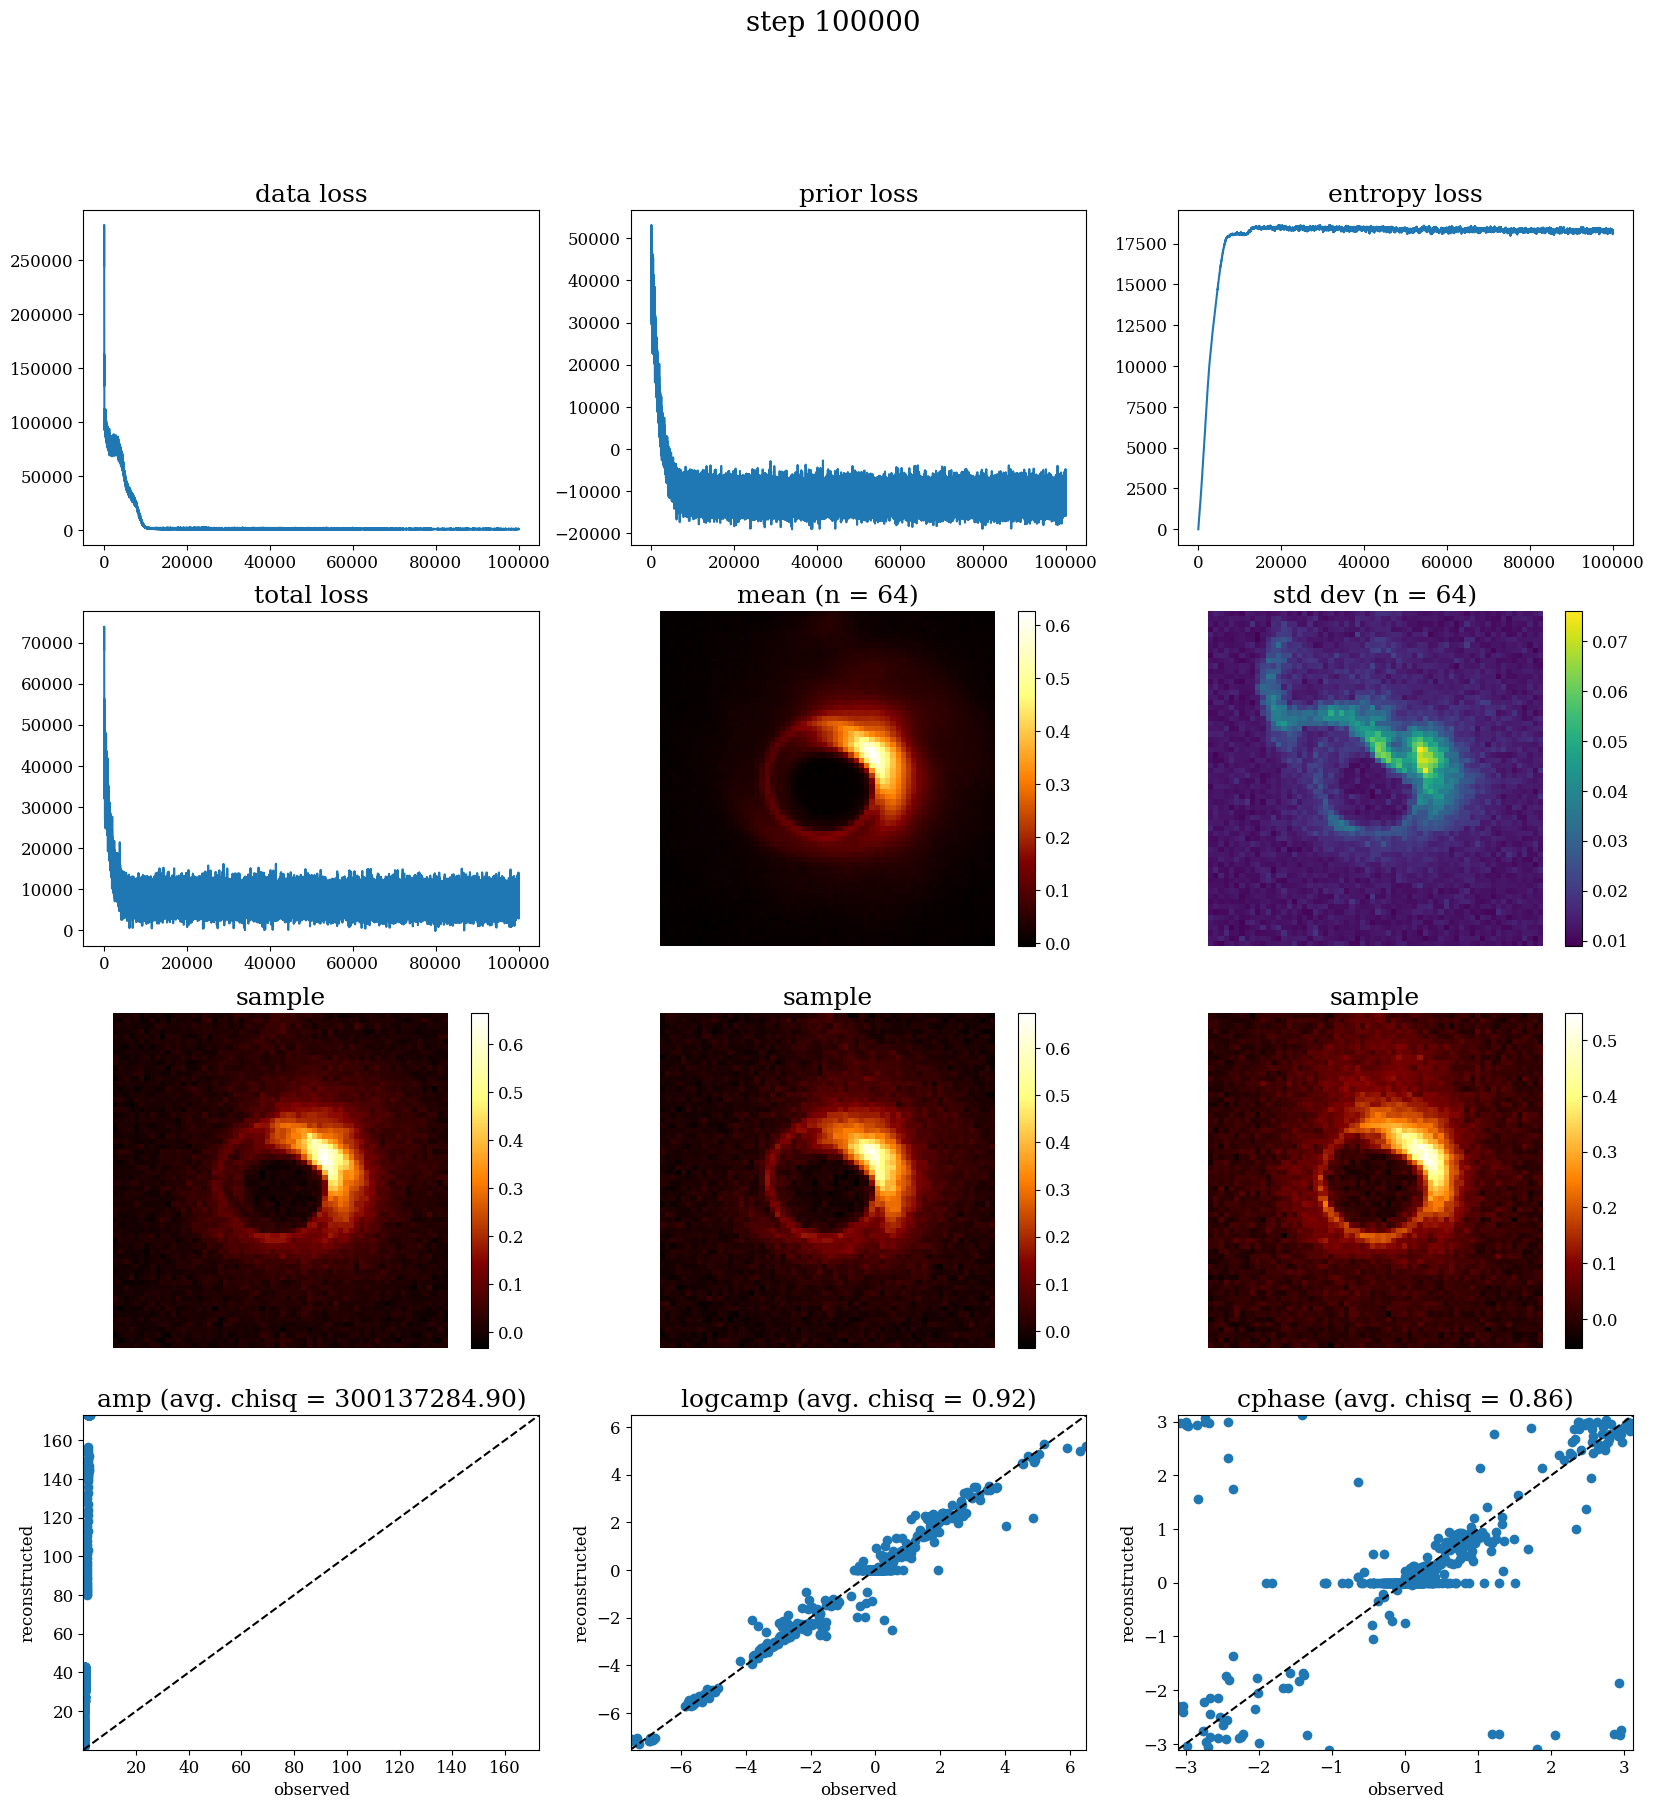

time/step: 0.20 sec
data weight:  1.0e+00


In [10]:
"""
We iteratively sample from the RealNVP, estimate its KL divergence to the target posterior,
and update the RealNVP parameters with gradients to minimize the KL divergence.
"""
initialize = True
rejit_step_fn = True  # Set to `False` to save time re-jitting step function.

load_checkpoint = False
save_ckpts = False
ckpt_freq = 10000  # Save DPI checkpoint every `ckpt_freq` steps.
ckpt_dir = 'checkpoints/interferometry'
vis_freq = 50  # Visualize DPI progress every `vis_freq` steps.

if save_ckpts:
  os.makedirs(ckpt_dir, exist_ok=True)

if initialize:
  losses_total, losses_data, losses_prior, losses_entropy, losses_flux = [], [], [], [], []

  # Initialize model.
  model, model_state, params = dpi_mutils.get_model_and_init_params(
      config,
      train=True)
  
  # Initialize optimizer.
  optimizer = optax.adam(
      learning_rate=config.optim.learning_rate,
      b1=config.optim.adam_beta1, b2=config.optim.adam_beta2,
      eps=config.optim.adam_eps)
  opt_state = optimizer.init(params)
  
  # Initialize training state.
  state = dpi_mutils.State(
    step=0,
    opt_state=opt_state,
    params=params,
    model_state=model_state,
    data_weight=1.,
    prior_weight=1.,
    entropy_weight=1.,
    rng=jax.random.PRNGKey(config.seed + 1))
  
  if load_checkpoint:
    state = flax.training.checkpoints.restore_checkpoint(ckpt_dir, state)
  print(f'Starting from step {state.step}', flush=True)

  # Replicate training state.
  pstate = flax.jax_utils.replicate(state)

if rejit_step_fn:
  step_fn = get_step_fn(model, optimizer)
  p_train_step = jax.pmap(jax.jit(step_fn), axis_name='batch')


n_steps = 100000
init_step = flax.jax_utils.unreplicate(pstate.step)
rng = state.rng

for step in range(init_step, n_steps):
  start_time = time.perf_counter()

  if config.optim.anneal_data:
    data_weight = data_weight_fn(
        step,
        rate=config.optim.data_annealing_rate,
        pivot_steps=config.optim.data_annealing_pivot)
    pstate = pstate.replace(
        data_weight=flax.jax_utils.replicate(data_weight))

  # Train step.
  rng, step_rngs = utils.psplit(rng)
  pstate, (ploss, ploss_data, ploss_prior, ploss_entropy, ploss_flux), psamples = p_train_step(
      step_rngs, pstate)

  # Unreplicate losses, samples.
  loss = flax.jax_utils.unreplicate(ploss).item()
  loss_data = flax.jax_utils.unreplicate(ploss_data).item()
  loss_prior = flax.jax_utils.unreplicate(ploss_prior).item()
  loss_entropy = flax.jax_utils.unreplicate(ploss_entropy).item()
  loss_flux = flax.jax_utils.unreplicate(ploss_flux).item()
  samples = psamples.reshape(config.training.batch_size, *image_shape)

  # Update losses.
  losses_total.append(loss)
  losses_data.append(loss_data)
  losses_prior.append(loss_prior)
  losses_entropy.append(loss_entropy)
  losses_flux.append(loss_flux)

  step_time = time.perf_counter() - start_time

  if save_ckpts and ((step + 1) % ckpt_freq == 0):
    # Save model checkpoint.
    flax.training.checkpoints.save_checkpoint(
      ckpt_dir,
      flax.jax_utils.unreplicate(pstate),
      step=step + 1,
      keep=np.inf)

  if (step + 1) % vis_freq == 0 or step == 0:
    ipd.clear_output(wait=True)
    fig = plot_dpi_progress_inteferometry(
        step + 1, samples, likelihood, losses_total, losses_data, losses_prior, losses_entropy);
    plt.show()
    print(f'time/step: {step_time:.2f} sec', flush=True)
    print(f'data weight: {data_weight: .1e}', flush=True)

### Evaluate samples

In [12]:
"""
We can sample from the optimized RealNVP to obtain samples from the
approximate posterior.
"""

# Get the sampling function of the optimized RealNVP in eval mode.
state = flax.jax_utils.unreplicate(pstate)
eval_model, _, _ = dpi_mutils.get_model_and_init_params(config, train=False)
sample_fn = dpi_mutils.get_sampling_fn(eval_model, state.params, state.model_state, train=False)

# Occasionally, sampling with the RealNVP may be unstable.
# We reject any image samples whose pixel values are far
# outside of [0, 1] and any that do not have close to the
# correct total flux.
def is_valid_fn(image):
  """Filtering function for DPI sample."""
  within_range = np.all((image > -0.5) & (image < 1.5))
  satisfies_total_flux = np.allclose(np.sum(image), config.likelihood.interferometry.target_flux, rtol=0.1)
  return within_range and satisfies_total_flux

def get_valid_sample_fn(sample_fn, is_valid_fn, image_shape, batch_size):
  def valid_sample_fn(rng, n_samples):
    """Use rejection sampling to get `n_samples` samples."""
    samples = np.zeros((n_samples, *image_shape))
    logdets = np.zeros(n_samples)
    n_current_samples = 0
    sample_sizes = []
    while n_current_samples < n_samples:
      rng, step_rng = jax.random.split(rng)
      (samp, logdet), _ = sample_fn(step_rng, (batch_size, *image_shape))
      valid_samp = []
      for s in samp:
        if is_valid_fn(s):
          valid_samp.append(s)
      valid_samp = np.array(valid_samp)
      n_valid_samp = valid_samp.shape[0]
      print(f'{n_valid_samp} valid samples', flush=True)
      if n_valid_samp == 0:
        continue
      n_valid_samp = min(n_valid_samp, n_samples - n_current_samples)
      samples[n_current_samples:n_current_samples + n_valid_samp] = valid_samp[:n_valid_samp]
      n_current_samples += n_valid_samp
    return samples
  return valid_sample_fn

valid_sample_fn = get_valid_sample_fn(sample_fn, is_valid_fn, image_shape, batch_size=256)

# Get valid samples from the RealNVP-approximated posterior.
sample_rng = jax.random.PRNGKey(0)
samples = valid_sample_fn(rng, 128)

# We will rescale the images (whose pixels are usually in [0, 1]) so that the
# total flux of the image equals the assumed zero-baseline flux (in this case, 2).
flux_multiplier = config.likelihood.interferometry.zbl / config.likelihood.interferometry.target_flux

# We will scale the images by `brightness_factor` to plot images in terms of
# the brightness temperature [10^{10} K].
brightness_factor = 3.254e13 / (true_im.rf**2 * true_im.psize**2)
brightness_factor /= 1e10

samples *= flux_multiplier * brightness_factor

Getting orders...
Initializing params and model state...
252 valid samples


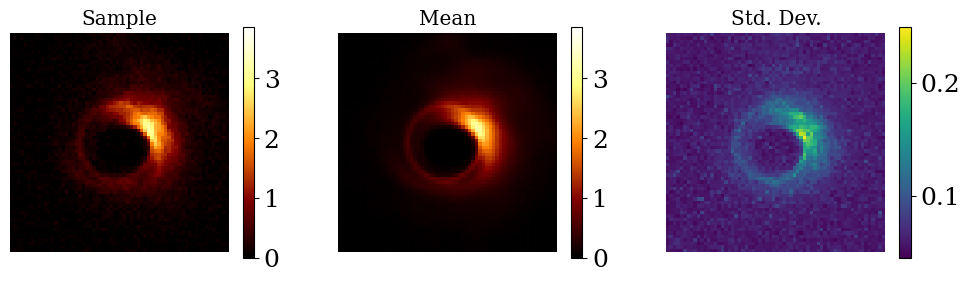

In [13]:
# We will view the mean, pixel-wise std. dev., and a random sample
# of the posterior.
mean = np.mean(samples, axis=0)
std = np.std(samples, axis=0)
sample = samples[np.random.RandomState(0).randint(len(samples))]

true_image = true_im.ivec * brightness_factor
vmax = max(true_image.max(), sample.max(), mean.max())

fig = plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.imshow(sample, cmap='afmhot', clim=(0, vmax)); plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.title('Sample')
plt.subplot(132)
plt.imshow(mean, cmap='afmhot', clim=(0, vmax)); plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.title('Mean')
plt.subplot(133)
plt.imshow(std, cmap='viridis'); plt.axis('off')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
plt.title('Std. Dev.');